## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_3params_v2 as n_counts_simulator
#importlib.reload(n_counts_simulator)

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])
n_params = len(theta_fiducial)

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_3params_v2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_3params_v2.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

N_countsSimulator.N_counts

total: 0.9870619299999999 s


array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [9]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [10]:
N_countsSimulator.n_counts_trapz(theta_fiducial, 0.1, 0.2, 14.0, 14.5)

computing cosmo: 0.00014898100000015901 s
computing halo mass function object: 0.13933349199999956 s
computing factors: 0.12423437100000001 s
loop over z_steps: 0.035389881999999595 s


0.0

In [11]:
N_countsSimulator.n_counts_trapz_all_new(theta_fiducial, z_min, z_max, log10masses)

total: 0.8947081629999998 s


array([1.78485558e+04, 5.76970955e+04, 7.91959673e+04, 7.60280551e+04,
       5.88513395e+04, 2.53149917e+03, 6.50857065e+03, 6.79905624e+03,
       4.77690342e+03, 2.60821304e+03, 1.41326957e+02, 2.40973379e+02,
       1.54407659e+02, 6.19686706e+01, 1.80224732e+01, 1.15792928e+00,
       8.97137339e-01, 2.22002922e-01, 2.95445872e-02, 2.45078214e-03])

In [12]:
N_countsSimulator.N_counts.shape

(20,)

In [13]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up fake compressor for now

In [14]:
def compressor(data, compressor_args):
    return data
compressor_args=None

## Load data

In [15]:
N_counts_data = np.load('N_counts_random_data.npy')
N_counts_data

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

## Define ensemble of NDEs

In [16]:
NDEs1 = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=20, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=20, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [17]:
DelfiEnsemble = delfi.Delfi(N_counts_data.reshape(20), prior, NDEs1, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\Omega_{b}h^{2}', '\\sigma_{8}'],
                            results_dir = "simulators/mass_function_n_counts/results/")

## Sequential Neural Likelihood

In [18]:
n_initial = 10 #200
n_batch = 20 #200
n_populations = 5 #20

total: 0.8664879289999998 s
total: 0.8684599379999991 s
total: 0.8616428129999996 s
total: 0.8723856019999978 s
total: 0.8712852010000027 s
total: 0.87607225 s
total: 0.8870202020000022 s
total: 0.8885175720000014 s
total: 0.8847050570000015 s
total: 0.8855335460000013 s


Population 1/5
Sampling proposal density...
Done.


total: 0.8802705239999966 s
total: 0.8680985210000074 s
total: 0.8688686870000026 s
total: 0.8865013590000075 s
total: 0.8869277200000028 s
total: 0.8855974979999957 s
total: 0.8861826699999966 s
total: 0.8879816030000001 s
total: 0.8871273979999899 s
total: 0.8879913819999956 s
total: 0.8882148570000084 s
total: 0.8868518800000089 s
total: 0.887251716999998 s
total: 0.8876933970000067 s
total: 0.8868419550000084 s
total: 0.8889032849999978 s
total: 0.889109660999992 s
total: 0.8873255170000078 s
total: 0.8927905460000147 s
total: 0.8862178130000018 s


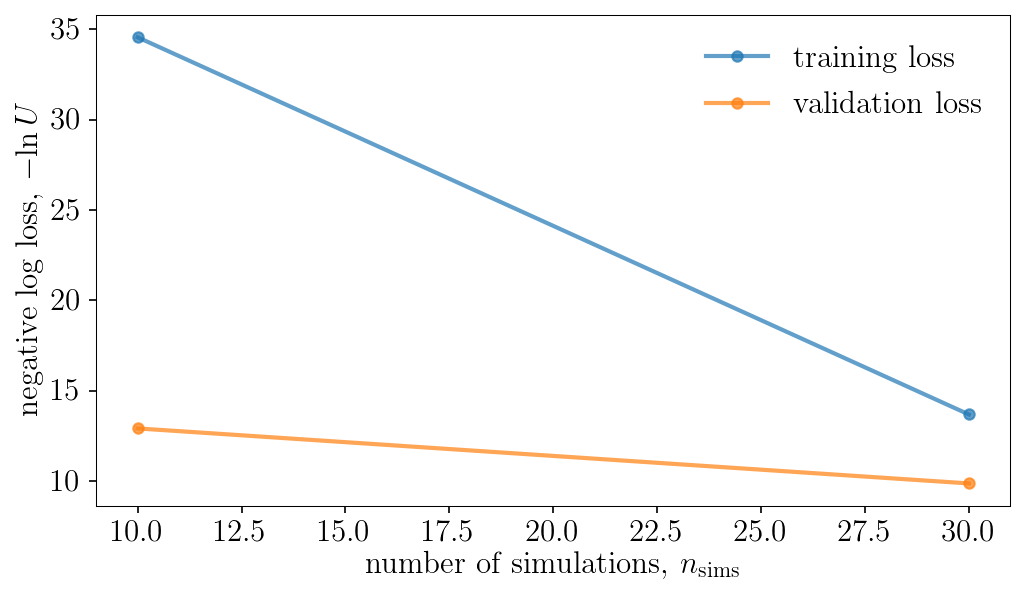

Population 2/5
Sampling proposal density...
Done.


total: 0.881932938999995 s
total: 0.8826548259999925 s
total: 0.8830426869999997 s
total: 0.8833810809999818 s
total: 0.8844407819999844 s
total: 0.888644907000014 s
total: 0.8843790370000022 s
total: 0.8857521589999919 s
total: 0.8907788920000144 s
total: 0.8828132799999935 s
total: 0.8892254030000117 s
total: 0.8880599149999853 s
total: 0.8862956199999985 s
total: 0.8828913030000081 s
total: 0.8877408070000001 s
total: 0.8836391380000066 s
total: 0.8844957249999936 s
total: 0.882209955999997 s
total: 0.8855441190000022 s
total: 0.8845914329999971 s


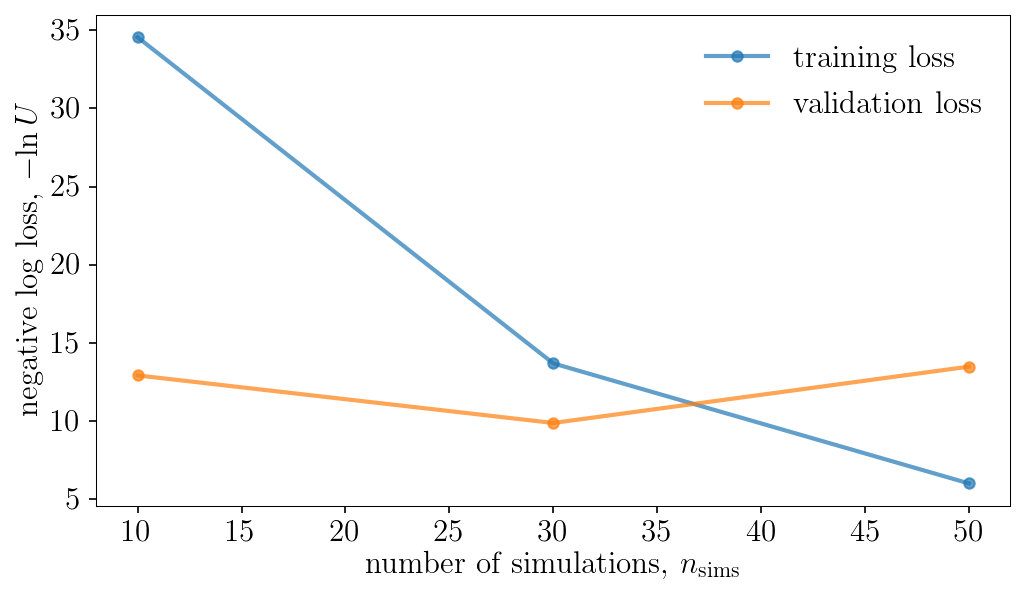

Population 3/5
Sampling proposal density...
Done.


total: 0.8952424060000226 s
total: 0.8877918379999983 s
total: 0.8836064189999888 s
total: 0.8972870669999793 s
total: 0.8845679880000148 s
total: 0.8882624449999525 s
total: 0.8908514560000071 s
total: 0.8828272690000176 s
total: 0.8877770290000058 s
total: 0.8880502209999577 s
total: 0.8832827649999899 s
total: 0.8860977740000067 s
total: 0.8889261450000276 s
total: 0.8845452420000015 s
total: 0.8872120940000059 s
total: 0.8833652609999945 s
total: 0.8844749929999693 s
total: 0.8821670970000355 s
total: 0.8856951280000089 s
total: 0.888948680999988 s


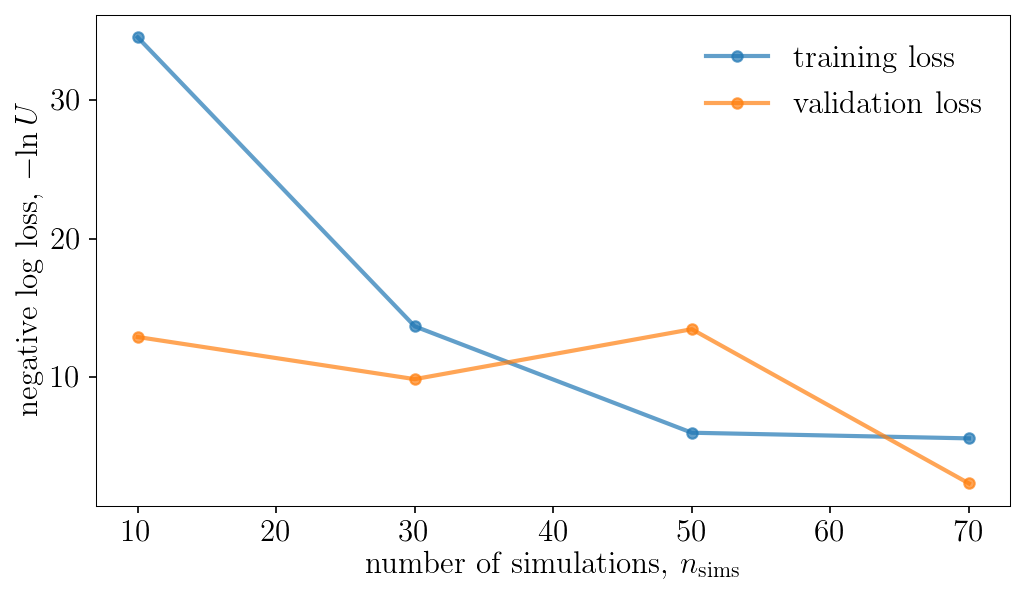

Population 4/5
Sampling proposal density...
Done.


total: 0.8934163300000364 s
total: 0.8827203030000419 s
total: 0.8819906310000079 s
total: 0.8855481360000113 s
total: 0.8842180229999599 s
total: 0.8832103270000289 s
total: 0.8826742410000179 s
total: 0.8835648119999746 s
total: 0.8821956379999847 s
total: 0.8834286790000192 s
total: 0.8816646739999783 s
total: 0.8835201979999852 s
total: 0.8827805269999658 s
total: 0.8843982869999536 s
total: 0.8832076630000074 s
total: 0.8845037319999847 s
total: 0.8829741650000074 s
total: 0.886994962000017 s
total: 0.8820405899999741 s
total: 0.8845248080000374 s


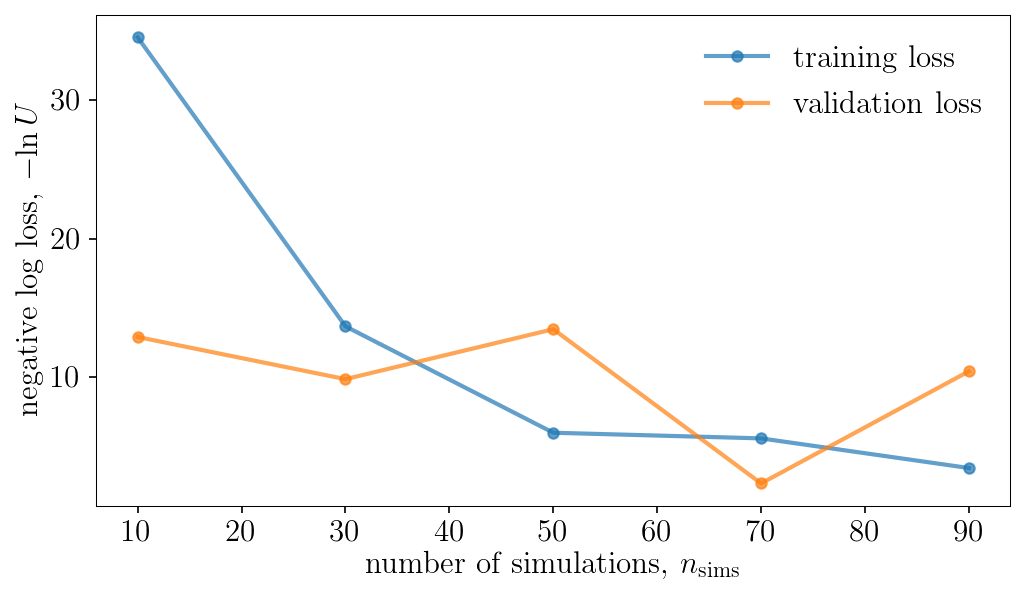

Population 5/5
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.8861490769999136 s
total: 0.8838379729999133 s
total: 0.8822158400000717 s
total: 0.8858638389999669 s
total: 0.8821154900000465 s
total: 0.8822472729999618 s
total: 0.8821432749999758 s
total: 0.88594388599995 s
total: 0.8831224990000237 s
total: 0.8829225610001004 s
total: 0.8835609089999252 s
total: 0.8863760640000464 s
total: 0.8816519759999437 s
total: 0.881774369000027 s
total: 0.8834441870000092 s
total: 0.8827011299999867 s
total: 0.8841785850000861 s
total: 0.8831827180000573 s
total: 0.8820931559999963 s
total: 0.8820299899999782 s


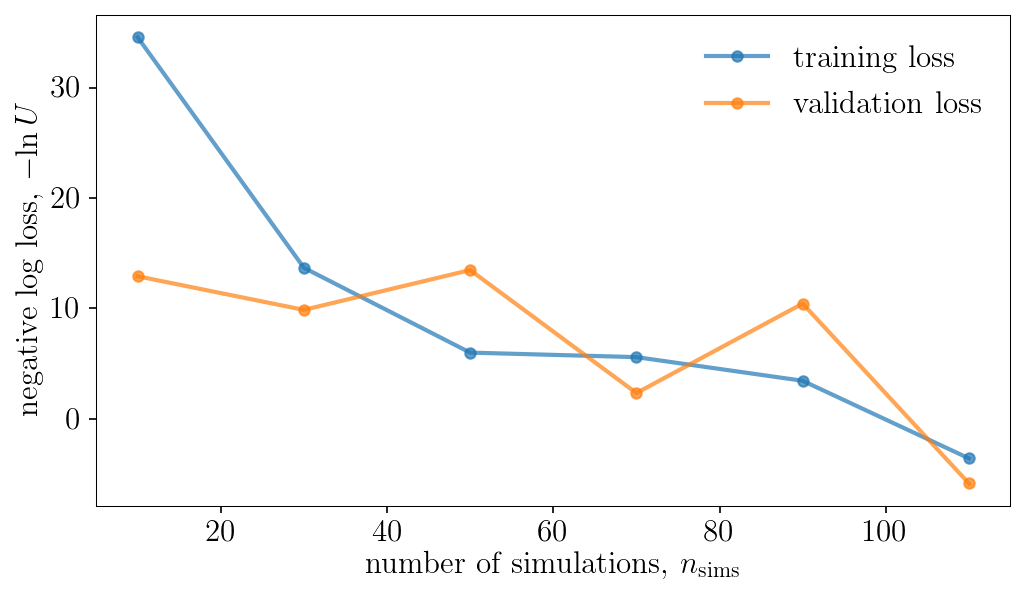

In [19]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

## Sample the learned posterior

In [20]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

Removed no burn in


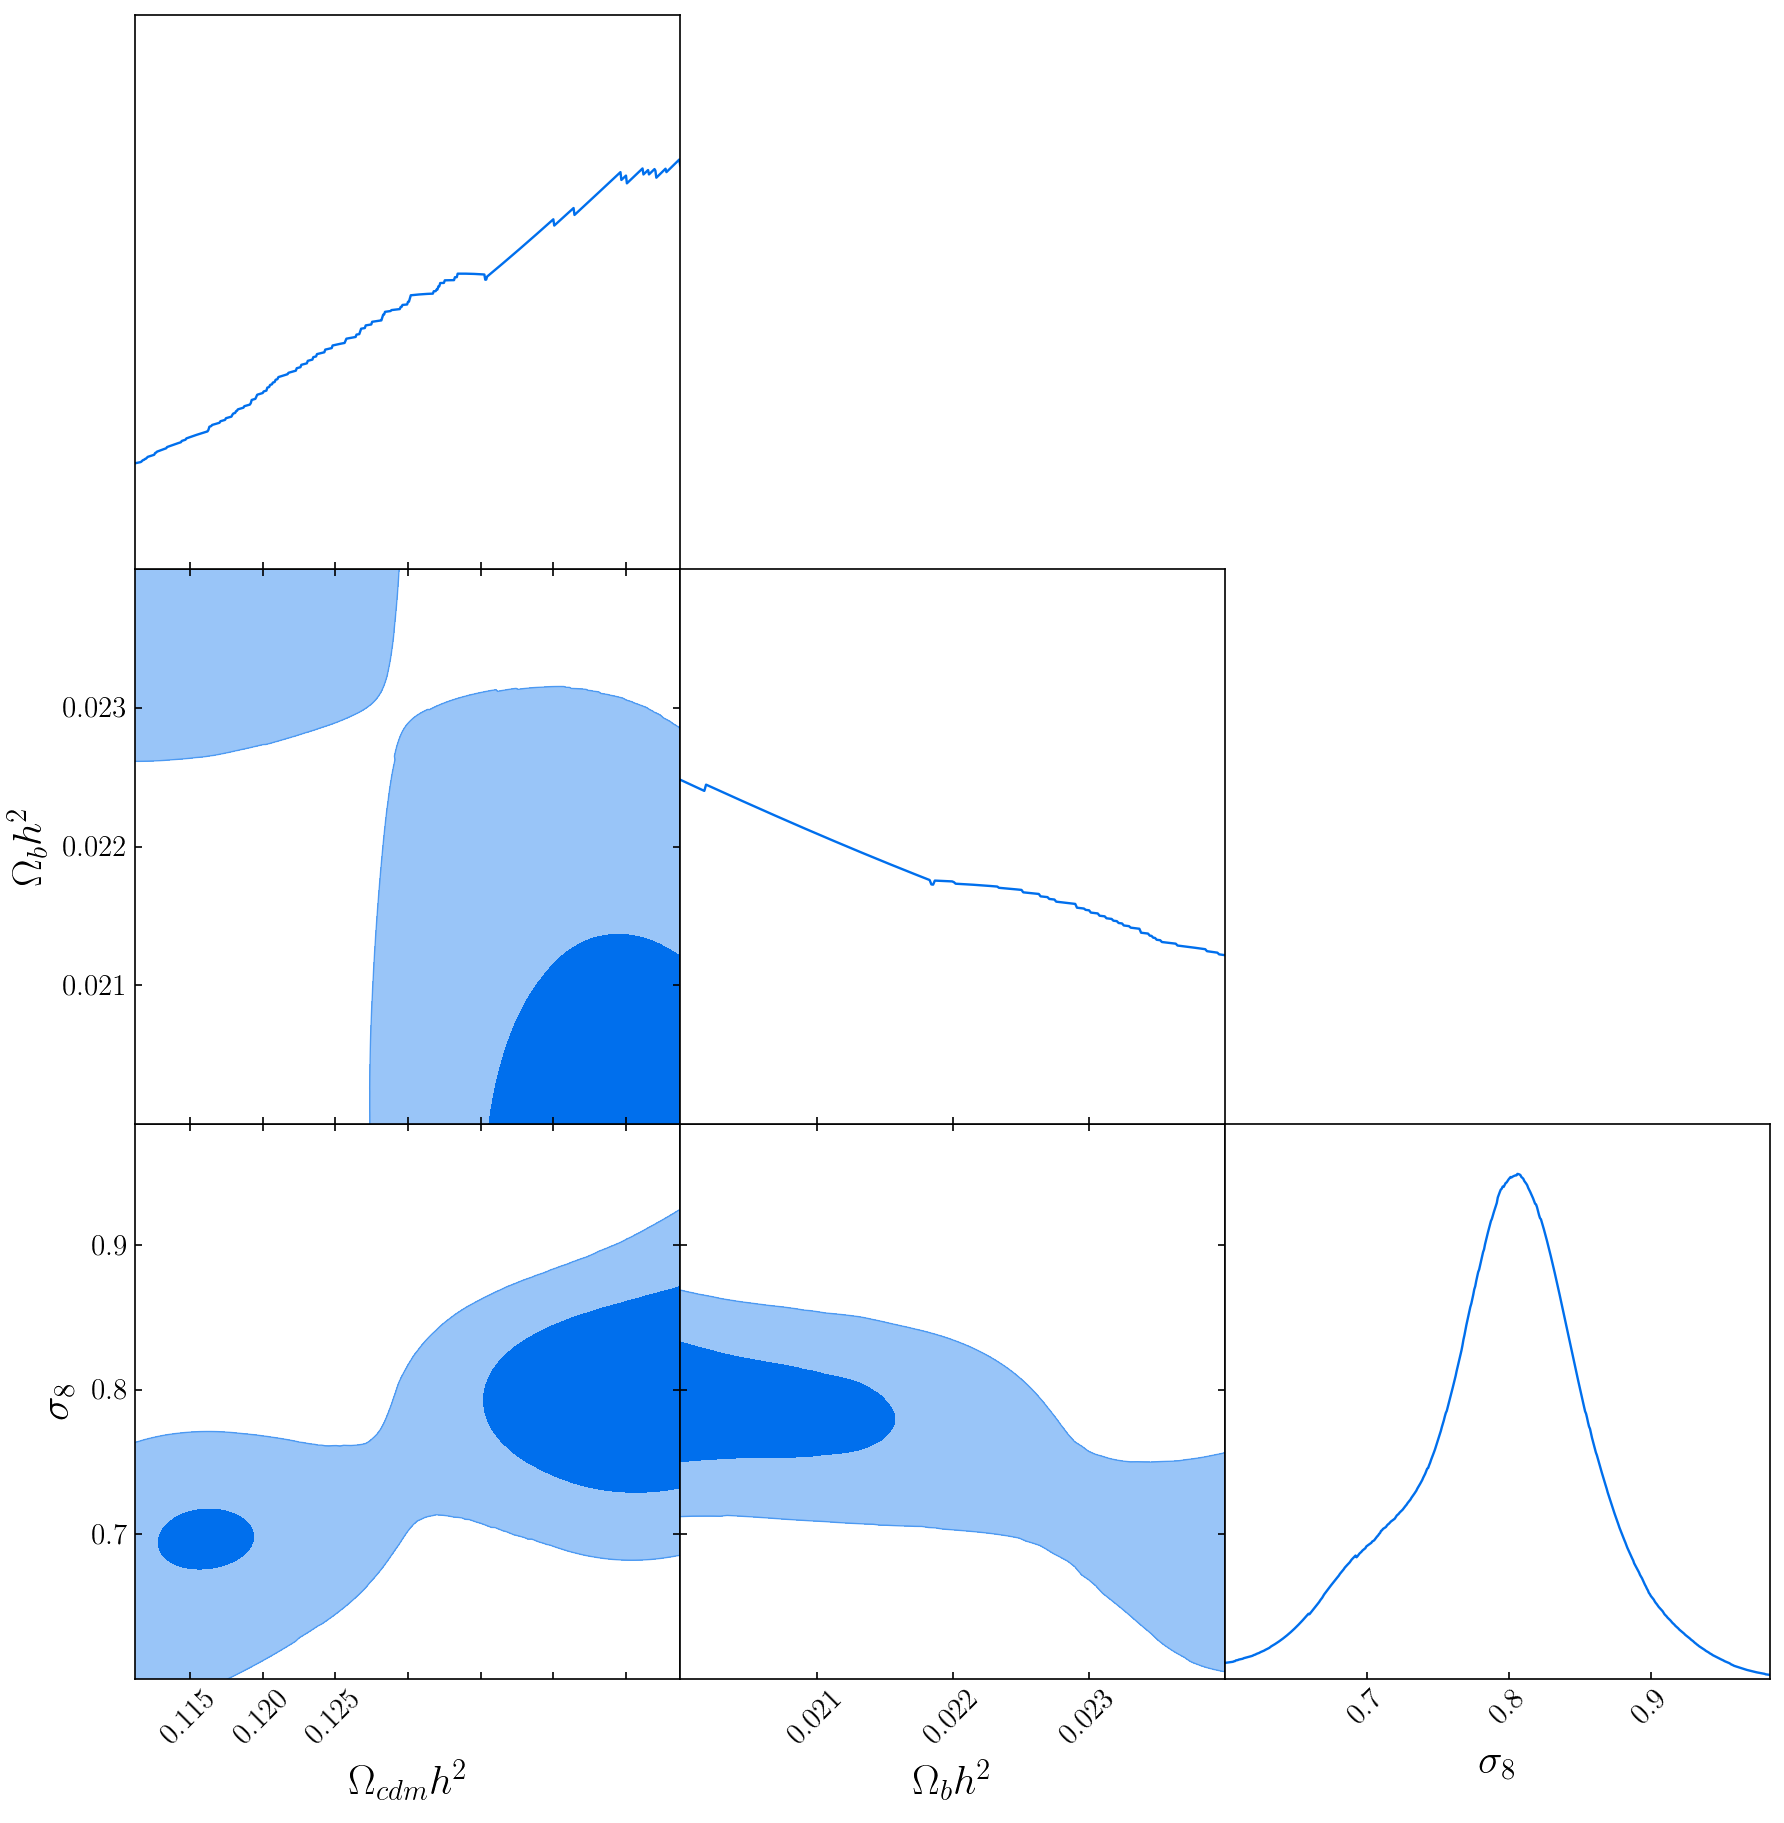

<Figure size 900x600 with 0 Axes>

In [21]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params_v2.png')

## Attempt 2

In [18]:
n_initial = 10 #200
n_batch = 20 #200
n_populations = 10 #20

total: 0.8863145630000009 s
total: 0.8798547060000015 s
total: 0.8749187249999988 s
total: 0.8752189330000029 s
total: 0.8714516369999998 s
total: 1.042114779000002 s
total: 0.8755513219999997 s
total: 0.8808021199999985 s
total: 0.8731408160000029 s
total: 0.884982701000002 s


Population 1/10
Sampling proposal density...
Done.


total: 0.8884374489999942 s
total: 0.8996660050000003 s
total: 0.8874230849999947 s
total: 0.8893621499999966 s
total: 0.8920638669999903 s
total: 0.887720110999993 s
total: 0.8901617610000017 s
total: 0.8902420490000083 s
total: 0.8894387209999906 s
total: 0.8897255560000019 s
total: 0.8901635640000052 s
total: 0.8898587250000105 s
total: 0.8894471129999886 s
total: 0.8907688550000046 s
total: 0.8906559879999918 s
total: 0.8892708370000264 s
total: 0.8893461520000017 s
total: 0.890304341000018 s
total: 0.8899314280000112 s
total: 0.888424864000001 s


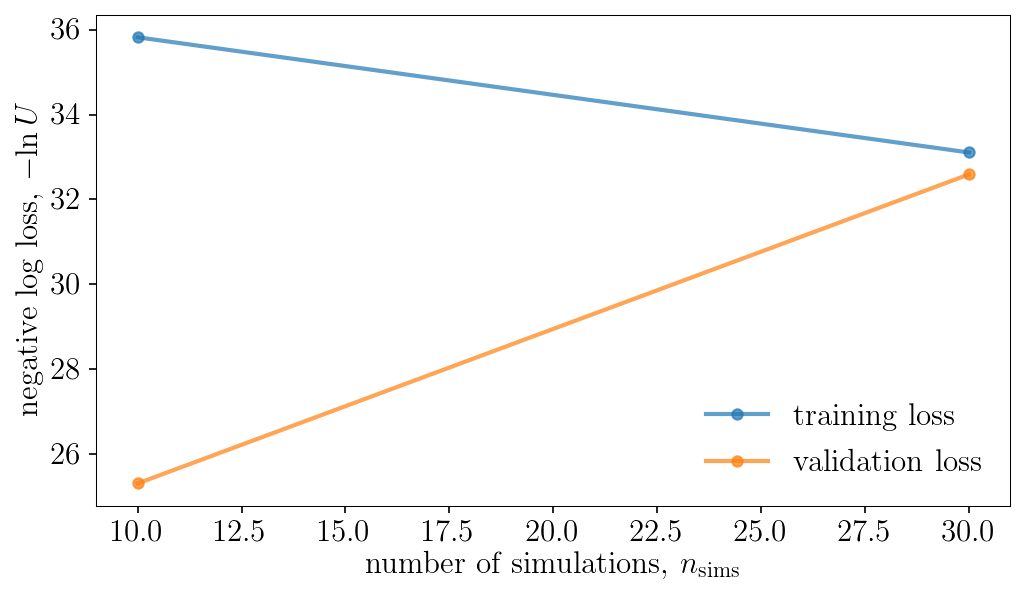

Population 2/10
Sampling proposal density...
Done.


total: 0.8841514389999929 s
total: 0.8830697870000108 s
total: 0.8801980199999946 s
total: 0.8834639700000082 s
total: 0.8822470890000034 s
total: 0.8824646940000207 s
total: 0.8834593659999825 s
total: 0.8822821239999996 s
total: 0.8825420780000002 s
total: 0.8829787890000205 s
total: 0.8849968049999859 s
total: 0.8823968050000133 s
total: 0.8815099360000147 s
total: 0.8797410919999891 s
total: 0.8748295999999982 s
total: 0.8761865580000006 s
total: 0.8740946709999946 s
total: 0.8749565029999928 s
total: 0.8759454870000241 s
total: 0.8756238260000089 s


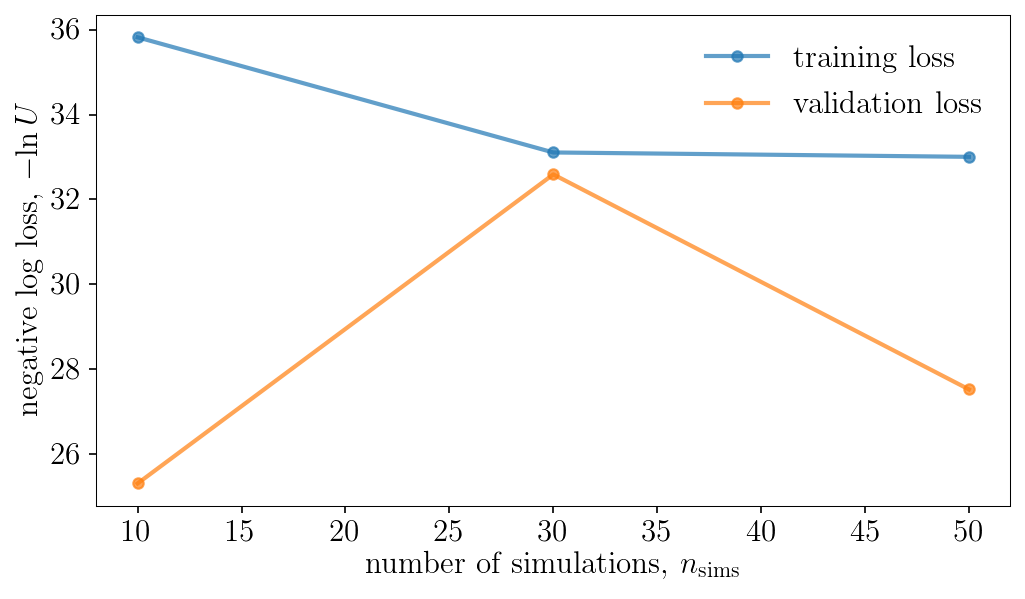

Population 3/10
Sampling proposal density...
Done.


total: 0.8870763980000334 s
total: 0.8863683619999847 s
total: 0.8826598740000122 s
total: 0.8837108010000065 s
total: 0.885631907000004 s
total: 0.881113417999984 s
total: 0.8827097399999957 s
total: 0.8835218120000263 s
total: 0.8914272389999951 s
total: 0.8834006499999987 s
total: 0.8820825449999461 s
total: 0.8819204440000021 s
total: 0.8829497919999767 s
total: 0.8829953619999742 s
total: 0.882477171000005 s
total: 0.8825612320000005 s
total: 0.8754133830000228 s
total: 0.8801069329999791 s
total: 0.8878412340000068 s
total: 0.8823825650000003 s


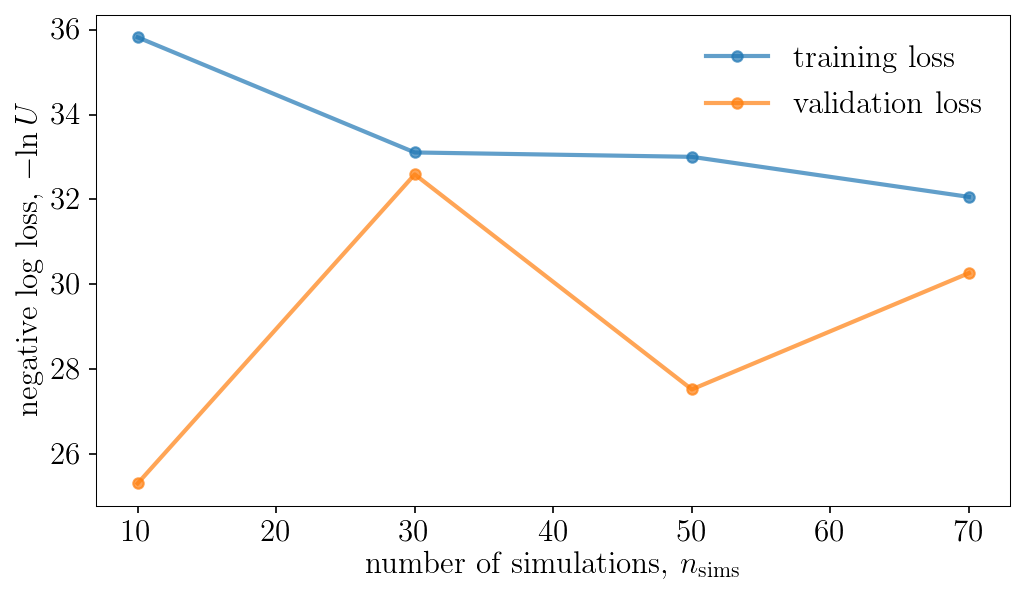

Population 4/10
Sampling proposal density...
Done.


total: 0.8836791150000067 s
total: 0.8856432219999988 s
total: 0.8885092900000018 s
total: 0.8818133040000475 s
total: 0.880533808999985 s
total: 0.8817424730000312 s
total: 0.8905769929999678 s
total: 0.8899947939999606 s
total: 0.882492238999987 s
total: 0.883102053000016 s
total: 0.8860430109999697 s
total: 0.885524485000019 s
total: 0.882261197000048 s
total: 0.8824187029999848 s
total: 0.8787120750000099 s
total: 0.8782332279999991 s
total: 0.8789343550000126 s
total: 0.8830377780000163 s
total: 0.8813320900000008 s
total: 0.8831695939999804 s


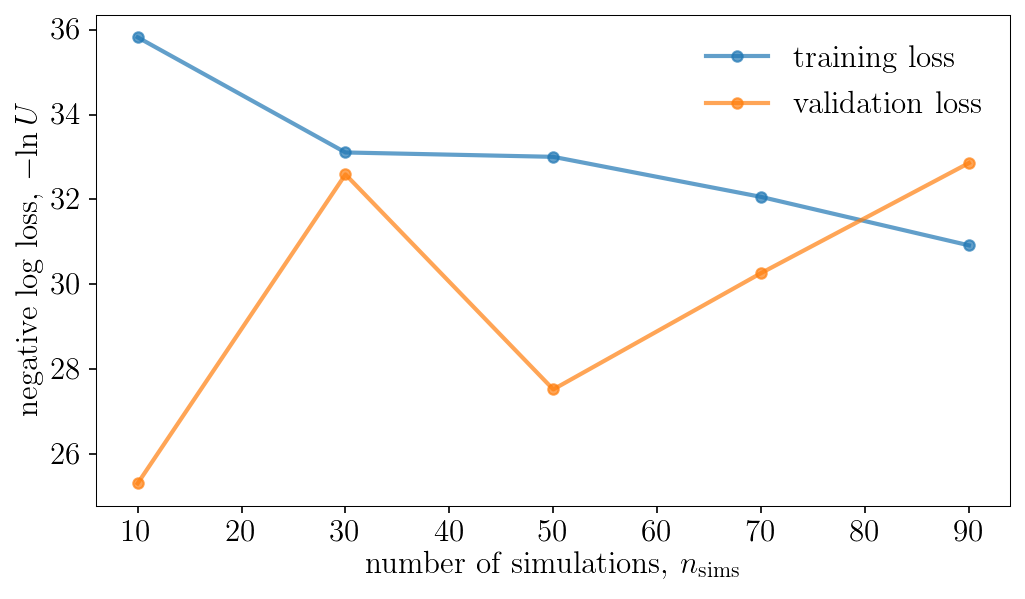

Population 5/10
Sampling proposal density...
Done.


total: 0.8828036969999857 s
total: 0.8814610250000214 s
total: 0.8868520519999947 s
total: 0.8803590390000409 s
total: 0.8804485179999801 s
total: 0.8802964960000281 s
total: 0.8781163499999138 s
total: 0.8776724629999535 s
total: 0.8789276539999946 s
total: 0.883661072000109 s
total: 0.8846372929999688 s
total: 0.881151376000048 s
total: 0.8808935829999882 s
total: 0.8794534979999753 s
total: 0.8796806010000182 s
total: 0.8848472429999674 s
total: 0.8806031340000118 s
total: 0.8793899549999651 s
total: 0.8800422299999582 s
total: 0.883192079999958 s


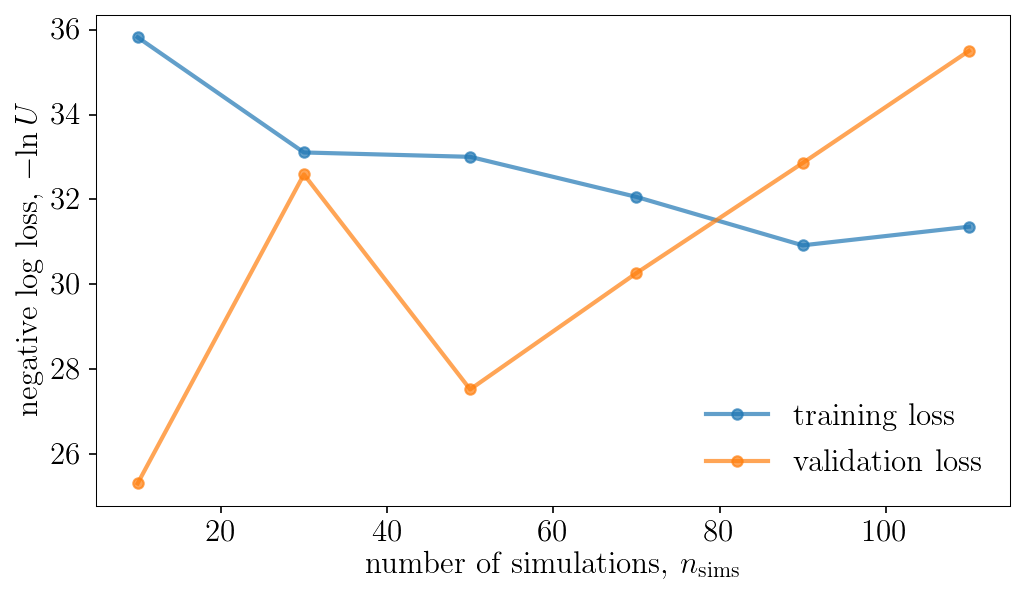

Population 6/10
Sampling proposal density...
Done.


total: 0.8822185889999901 s
total: 0.8781376370000089 s
total: 0.8795186580000518 s
total: 0.8777552919999607 s
total: 0.8774722240000301 s
total: 0.8757637619999059 s
total: 0.8746616970000787 s
total: 0.8814174560000083 s
total: 0.8775457420000521 s
total: 0.8776232520000349 s
total: 0.8828203069999745 s
total: 0.8792526019999514 s
total: 0.8753440259999934 s
total: 0.8787952679999762 s
total: 0.8812018840000064 s
total: 0.87829745800002 s
total: 0.8780487589999666 s
total: 0.8772326540000677 s
total: 0.8767983000000186 s
total: 0.8789866189999884 s


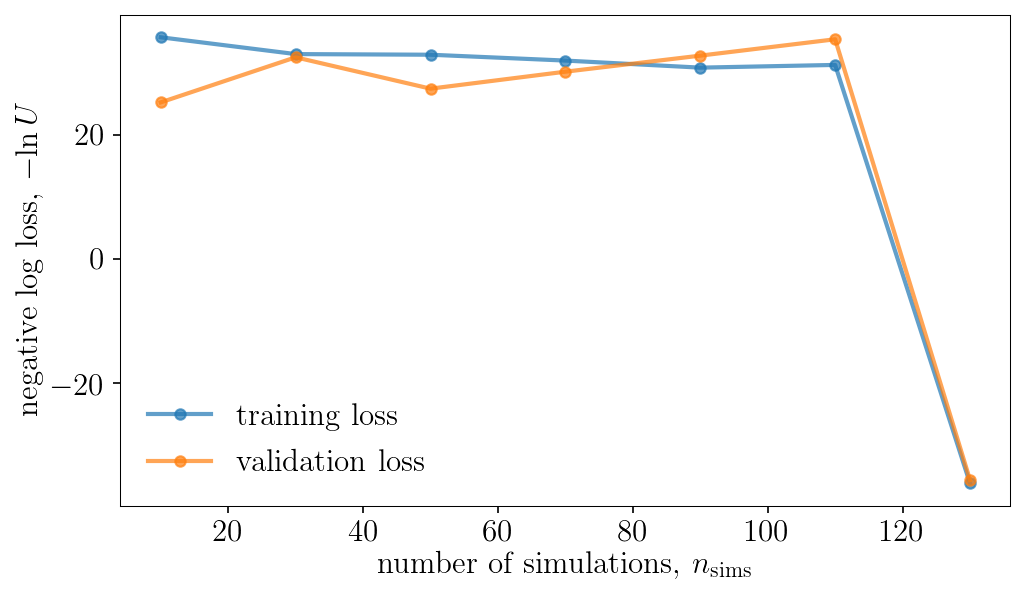

Population 7/10
Sampling proposal density...
Done.


total: 0.8882364989999587 s
total: 0.8851349050000863 s
total: 0.8910087619997284 s
total: 0.8882879879997745 s
total: 0.8876178199998321 s
total: 0.909014921999642 s
total: 0.9189125580001019 s
total: 0.886466505000044 s
total: 0.8885068279996631 s
total: 0.8862465459997111 s
total: 0.8863831319999917 s
total: 0.8869308289999935 s
total: 0.889627647999987 s
total: 0.8865573009998116 s
total: 0.8857124999999542 s
total: 0.8871847750001507 s
total: 0.8861906010001803 s
total: 0.8871680360002756 s
total: 0.8891388520000874 s
total: 0.8877836619999471 s


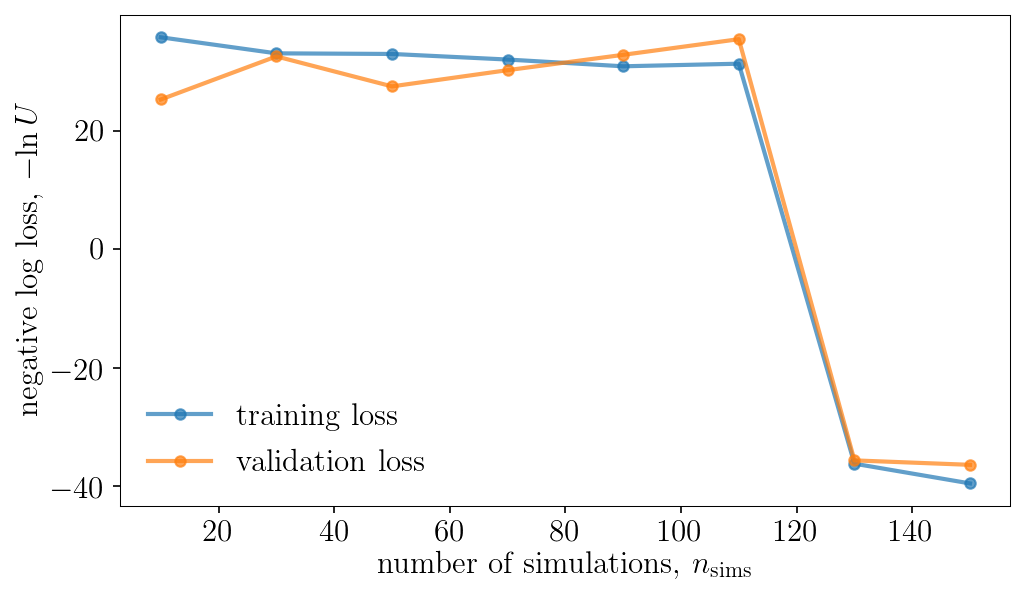

Population 8/10
Sampling proposal density...


/home/aizhana/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done.


total: 0.891819057000248 s
total: 0.8974450620007701 s
total: 0.9001651030002904 s
total: 0.8941543050004839 s
total: 0.9160356729998966 s
total: 0.8942294180005774 s
total: 0.8889325370000734 s
total: 0.8928754110002046 s
total: 0.8994279240005199 s
total: 0.8908878860002005 s
total: 0.8948717940002098 s
total: 0.8999795230001837 s
total: 0.8993298630002755 s
total: 0.8966168250008195 s
total: 0.9119721039996875 s
total: 0.9083682279997447 s
total: 0.9182678139995915 s
total: 0.8984845790000691 s
total: 0.8919014920002155 s
total: 0.8839312569998583 s


DataLossError: Checksum does not match: stored 1202248636 vs. calculated on the restored bytes 2661527340
	 [[node save_48/RestoreV2 (defined at /home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'save_48/RestoreV2':
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-46fedebff3fb>", line 2, in <module>
    save_intermediate_posteriors=False)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py", line 468, in sequential_training
    self.train_ndes(training_data=[self.x_train, self.y_train], batch_size=max(self.n_sims//8, batch_size), validation_split=0.1, epochs=epochs, patience=patience)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/delfi.py", line 508, in train_ndes
    val_loss, train_loss = self.trainer[n].train(self.sess, training_data, validation_split = validation_split, epochs=epochs, batch_size=batch_size, progress_bar=self.progress_bar, patience=patience, saver_name=self.graph_restore_filename, mode=mode)
  File "/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pydelfi/train.py", line 61, in train
    saver = tf.train.Saver()
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 828, in __init__
    self.build()
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 878, in _build
    build_restore=build_restore)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/aizhana/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [19]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=False)

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])
plt.savefig('posteriors_3params_v2_10populations.png')